<a href="https://colab.research.google.com/github/Tiagoeem/Ensaio_Sobre_o_AutoML/blob/main/Auto_ML_PyCaret_Rain_Aus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Para medir o tempo de execução do script
import time
ini = time.time()

# Instalando PyCaret

Instalando módulos para suporte a GPU, treinamento demorou demais nos primeiros testes. [PyCaret on GPU](https://pycaret.readthedocs.io/en/latest/installation.html)

In [ ]:
!pip install -U pandas-profiling

In [ ]:
!pip install pycaret

In [4]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


# Nota

Este notebook irá testar a performance da biblioteca Pycaret, será testado também a biblioteca H2O.ai em outro notebook ().

# Rain in Australia

Conjutno de dados - Rain in Australia: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

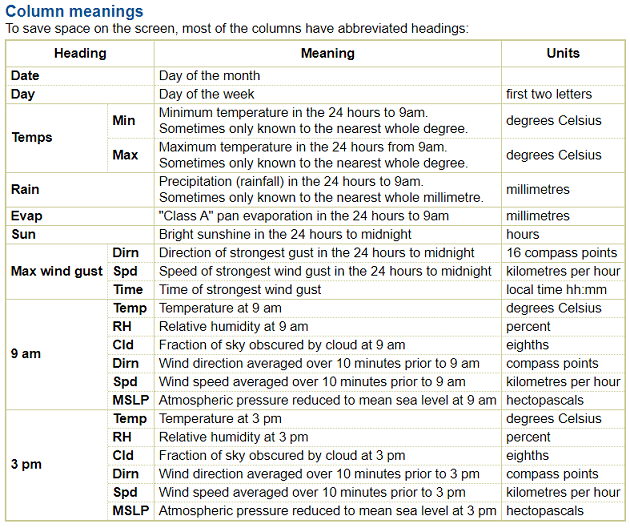

In [5]:
# Baixa o csv a partir de um link para que qualquer pessoa possa executar sem maiores dificuldades
# Uniformiza o trabalho e facilita o compartilhamento de códigos e notebooks
# Realiza o download dos dados e extrai para uma pasta conhecida
import zipfile
import gdown
import os

parent_dir = '/content'

file_name = 'rain_aus.csv'
output = os.path.join( parent_dir, file_name )

if not(os.path.isfile(output)):
    url = 'https://drive.google.com/u/0/uc?id=1eT05yNu1TvSXlcEdrgAGKAx7bdEEMrLl'
    gdown.download(url, output=output, quiet=True)


In [6]:
import pandas as pd

df_rain = pd.read_csv('rain_aus.csv')
df_rain.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No


In [7]:
# Risk_mm é label para regressão, deve ser removido
df_rain.drop(labels='RISK_MM', axis='columns', inplace=True)

In [8]:
df_rain.shape

(142193, 23)

# Análise Exploratória de Dados (*EDA*)

Utilizando o [Pandas Profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html#pandas-profiling) para um rápido EDA rápido.

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_rain)
profile.to_notebook_iframe()

# Separação de dados

Por padrão o Pycaret separa os dados em Treino e teste (70%, 30%). Mas uma boa pratica é remover de 5% a 10% dos dados para uma validação final após finalização de todo o processo de modelagem e treinamento.

In [10]:
df_validacao_final = df_rain.sample(frac=0.05, random_state=777)
df_rain.drop(df_validacao_final.index, inplace=True)
df_rain.reset_index(inplace=True, drop=True)

In [11]:
print(df_rain.shape)
print(df_validacao_final.shape)

(135083, 23)
(7110, 23)


# Pycaret com Parâmetros Default

The **setup()** function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. **setup()** must be called before executing any other function in pycaret. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [12]:
from pycaret.classification import *

clf_default = setup(df_rain, target = 'RainTomorrow', session_id=1, use_gpu=True, experiment_name='Pycaret Default Config - Rain')

,Description,Value
0,session_id,1
1,Target,RainTomorrow
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(135083, 23)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparando modelos

 
"Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case)." [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [13]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8582,0.8903,0.5442,0.7542,0.6321,0.5472,0.5584,1.962
rf,Random Forest Classifier,0.8552,0.8851,0.4951,0.7773,0.6047,0.5214,0.5414,24.009
et,Extra Trees Classifier,0.8515,0.8826,0.4728,0.7767,0.5876,0.5035,0.5267,33.117
gbc,Gradient Boosting Classifier,0.8502,0.8742,0.5021,0.7458,0.6000,0.5122,0.5274,40.258
lda,Linear Discriminant Analysis,0.8478,0.8714,0.5248,0.7196,0.6069,0.5154,0.5253,4.614
ridge,Ridge Classifier,0.8467,0.0000,0.4663,0.7553,0.5765,0.4892,0.5105,0.351
lr,Logistic Regression,0.8459,0.8678,0.5049,0.7233,0.5946,0.5032,0.5156,47.417
ada,Ada Boost Classifier,0.8436,0.8651,0.5031,0.7140,0.5902,0.4972,0.5088,9.037
knn,K Neighbors Classifier,0.8337,0.8105,0.4954,0.6753,0.5714,0.4712,0.4800,67.816
svm,SVM - Linear Kernel,0.8190,0.0000,0.4604,0.7240,0.4916,0.4018,0.4430,22.820


In [15]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


## Criando Modelos Individuais


### Utilizando o best: LGBM

In [16]:
#lightgbm
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8628,0.8931,0.5579,0.7659,0.6455,0.5631,0.5740
1,0.8532,0.8813,0.5182,0.7488,0.6125,0.5256,0.5392
2,0.8600,0.8962,0.5593,0.7517,0.6414,0.5567,0.5661
3,0.8623,0.8981,0.5569,0.7641,0.6443,0.5615,0.5723
4,0.8545,0.8871,0.5205,0.7532,0.6156,0.5296,0.5433
5,0.8574,0.8917,0.5557,0.7431,0.6359,0.5495,0.5585
6,0.8623,0.8910,0.5524,0.7677,0.6425,0.5600,0.5717
7,0.8583,0.8913,0.5411,0.7569,0.6311,0.5463,0.5581
8,0.8567,0.8885,0.5536,0.7408,0.6337,0.5469,0.5559
9,0.8547,0.8846,0.5267,0.7498,0.6188,0.5324,0.5450


## Tunando os Modelos

By default, tune_model optimizes Accuracy but this can be changed using optimize parameter. For example: tune_model(dt, optimize = 'AUC') will search for the hyperparameters of a Decision Tree Classifier that results in the highest AUC instead of Accuracy. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

### LightGBM

In [17]:
tuned_lgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8664,0.8999,0.5853,0.7629,0.6624,0.5809,0.5889
1,0.8564,0.8891,0.5456,0.7447,0.6298,0.5433,0.5534
2,0.8646,0.9009,0.5876,0.7535,0.6603,0.5774,0.5843
3,0.8657,0.9016,0.5829,0.7613,0.6602,0.5784,0.5864
4,0.8597,0.8955,0.5494,0.7572,0.6367,0.5525,0.5634
5,0.8610,0.8949,0.5784,0.7442,0.6509,0.5659,0.5729
6,0.8606,0.8938,0.5647,0.7513,0.6447,0.5602,0.5690
7,0.8591,0.8977,0.5562,0.7503,0.6388,0.5537,0.5633
8,0.8597,0.8934,0.5782,0.7382,0.6485,0.5624,0.5690
9,0.8567,0.8909,0.5546,0.7402,0.6341,0.5472,0.5561


## Validando os modelos (Métricas e Gráficos)


### Melhor modelo

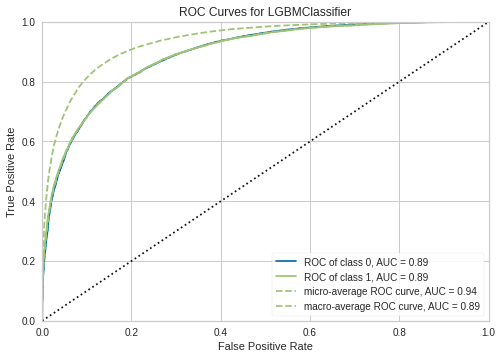

In [18]:
plot_model(tuned_lgbm, plot='auc')

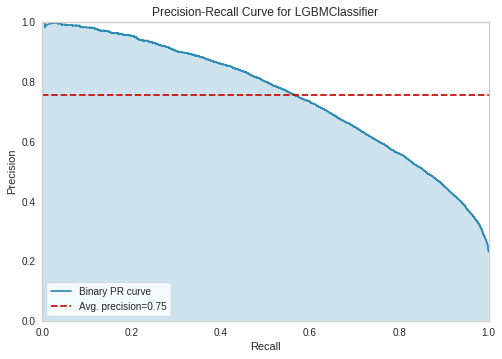

In [19]:
plot_model(tuned_lgbm, plot = 'pr')

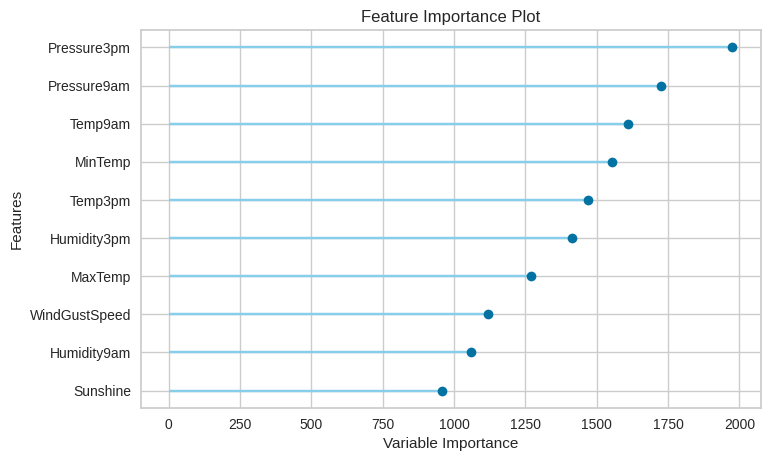

In [20]:
plot_model(tuned_lgbm, plot='feature')

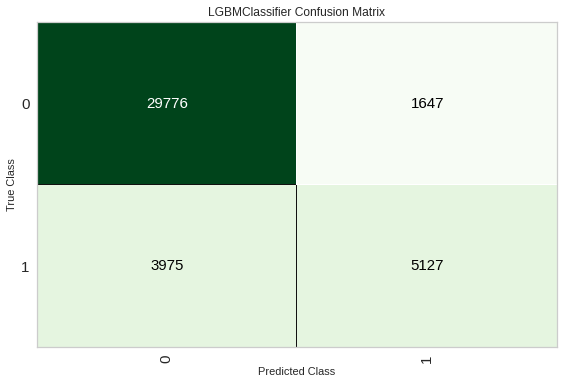

In [21]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

## Avaliando os conjunto de **Teste**

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

### LightGBM

In [36]:
predict_model(tuned_lgbm).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8613,0.8941,0.5633,0.7569,0.6459,0.5619,0.5714


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,...,Cloud9am_8.0,Cloud9am_9.0,Cloud9am_not_available,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_5.0,Cloud3pm_6.0,Cloud3pm_7.0,Cloud3pm_8.0,Cloud3pm_not_available,RainToday_No,RainToday_Yes,RainToday_not_available,Date_month_1,Date_month_10,Date_month_11,Date_month_12,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_weekday_0,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_1,Date_is_month_start_1,RainTomorrow,Label,Score
0,12.7,19.600000,9.4,4.600000,10.3,52.0,28.0,33.0,70.0,51.0,1015.099976,1015.200012,14.500000,18.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,No,0.9412
1,22.1,30.500000,1.8,5.800000,10.4,39.0,15.0,20.0,68.0,55.0,1016.700012,1015.099976,26.900000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.9151
2,17.0,35.799999,0.0,5.461089,11.8,61.0,20.0,13.0,54.0,29.0,1013.200012,1009.900024,25.700001,35.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.9574
3,8.5,25.900000,1.2,4.600000,7.6,37.0,17.0,17.0,63.0,22.0,1019.599976,1018.200012,15.500000,24.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.9908
4,7.9,18.299999,4.0,1.600000,6.2,35.0,17.0,22.0,61.0,64.0,1012.200012,1012.099976,14.400000,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.8452


## Realizando a Calibração dos Modelos

Verificar se existe melhora.

In [23]:
best_calib = calibrate_model(tuned_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8660,0.9015,0.5701,0.7717,0.6558,0.5749,0.5851
1,0.8548,0.8902,0.5376,0.7428,0.6237,0.5366,0.5474
2,0.8658,0.9024,0.5820,0.7624,0.6601,0.5783,0.5865
3,0.8662,0.9039,0.5791,0.7662,0.6597,0.5784,0.5872
4,0.8600,0.8976,0.5432,0.7631,0.6347,0.5511,0.5632
5,0.8629,0.8982,0.5779,0.7528,0.6538,0.5702,0.5780
6,0.8611,0.8980,0.5562,0.7595,0.6421,0.5585,0.5690
7,0.8619,0.8994,0.5581,0.7616,0.6441,0.5610,0.5714
8,0.8622,0.8971,0.5777,0.7494,0.6524,0.5683,0.5758
9,0.8566,0.8932,0.5475,0.7444,0.6309,0.5445,0.5544


In [37]:
predict_model(best_calib).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8623,0.8966,0.5578,0.7653,0.6453,0.5624,0.5732


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,...,Cloud9am_8.0,Cloud9am_9.0,Cloud9am_not_available,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_5.0,Cloud3pm_6.0,Cloud3pm_7.0,Cloud3pm_8.0,Cloud3pm_not_available,RainToday_No,RainToday_Yes,RainToday_not_available,Date_month_1,Date_month_10,Date_month_11,Date_month_12,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_weekday_0,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_1,Date_is_month_start_1,RainTomorrow,Label,Score
0,12.7,19.600000,9.4,4.600000,10.3,52.0,28.0,33.0,70.0,51.0,1015.099976,1015.200012,14.500000,18.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,No,0.9338
1,22.1,30.500000,1.8,5.800000,10.4,39.0,15.0,20.0,68.0,55.0,1016.700012,1015.099976,26.900000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.8815
2,17.0,35.799999,0.0,5.461089,11.8,61.0,20.0,13.0,54.0,29.0,1013.200012,1009.900024,25.700001,35.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.9192
3,8.5,25.900000,1.2,4.600000,7.6,37.0,17.0,17.0,63.0,22.0,1019.599976,1018.200012,15.500000,24.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.9464
4,7.9,18.299999,4.0,1.600000,6.2,35.0,17.0,22.0,61.0,64.0,1012.200012,1012.099976,14.400000,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,0.8485


## Finalizando o modelo

Modelo escolhido: LightGBM

The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [ ]:
final_model = finalize_model(best_calib)

In [38]:
print(final_model)

CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.9,
                                                     bagging_freq=2,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.6,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=100,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.6,
                                                     n_estimators=280,
                                             

In [26]:
# Visualizando os parametros do modelo que irá para Deploy
final_model.get_params()

{'base_estimator': LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=100, min_child_weight=0.001,
                min_split_gain=0.6, n_estimators=280, n_jobs=-1, num_leaves=70,
                objective=None, random_state=1, reg_alpha=0.1, reg_lambda=0.001,
                silent=True, subsample=1.0, subsample_for_bin=200000,
                subsample_freq=0),
 'base_estimator__bagging_fraction': 0.9,
 'base_estimator__bagging_freq': 2,
 'base_estimator__boosting_type': 'gbdt',
 'base_estimator__class_weight': None,
 'base_estimator__colsample_bytree': 1.0,
 'base_estimator__feature_fraction': 0.6,
 'base_estimator__importance_type': 'split',
 'base_estimator__learning_rate': 0.1,
 'base_estimator__max_depth': -1,
 'base_estimator__min_child_samples': 100,
 'base_estimator__mi

## Validação com dados nunca usados

In [27]:
df_unseen = predict_model(final_model, data=df_validacao_final)
df_unseen.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Label,Score
27336,2011-03-29,Richmond,14.4,27.3,0.0,NaN,NaN,ENE,31.0,NaN,NE,0.0,11.0,88.0,53.0,1026.4,1021.7,NaN,NaN,18.6,26.6,No,No,No,0.8818
91787,2011-08-23,Townsville,14.2,25.5,0.0,7.6,7.7,ESE,46.0,SSE,NE,24.0,17.0,46.0,50.0,1020.9,1017.8,1.0,7.0,20.8,22.2,No,No,No,0.8890
69099,2011-08-08,Mildura,6.6,15.4,2.0,1.2,4.5,W,48.0,W,WSW,20.0,22.0,93.0,77.0,1013.2,1010.9,8.0,7.0,9.0,12.9,Yes,Yes,Yes,0.5050
37157,2012-09-10,WaggaWagga,0.2,19.4,0.0,2.8,10.9,N,22.0,E,WNW,11.0,11.0,79.0,44.0,1026.3,1021.8,1.0,3.0,9.6,19.2,No,No,No,0.8958
45853,2012-01-20,Canberra,11.4,33.6,0.0,NaN,NaN,ENE,52.0,ENE,WNW,7.0,13.0,60.0,28.0,1016.4,1011.2,NaN,1.0,19.6,31.1,No,Yes,No,0.8208


In [35]:
from pycaret.utils import check_metric

print('Acc: ',check_metric(df_unseen['RainTomorrow'], df_unseen['Label'], metric = 'Accuracy'))
print('F1: ',check_metric(df_unseen['RainTomorrow'], df_unseen['Label'], metric = 'F1'))

Acc:  0.8523
F1:  0.5625


# Salvando o modelo

In [30]:
save_model(final_model,'Final_Cat_16maio2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='RainTomorrow',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                                                                       learning_rate=0.1,
                                                                       max_depth=-1,
                                                            

# Loading do Modelo (Exemplo)

In [31]:
modelo_salvo = load_model('/content/Final_Cat_16maio2021')

Transformation Pipeline and Model Successfully Loaded


In [34]:
predict_model(modelo_salvo, data=df_unseen).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Label,Score,Score
27336,2011-03-29,Richmond,14.4,27.3,0.0,NaN,NaN,ENE,31.0,NaN,NE,0.0,11.0,88.0,53.0,1026.4,1021.7,NaN,NaN,18.6,26.6,No,No,No,0.8818,0.8818
91787,2011-08-23,Townsville,14.2,25.5,0.0,7.6,7.7,ESE,46.0,SSE,NE,24.0,17.0,46.0,50.0,1020.9,1017.8,1.0,7.0,20.8,22.2,No,No,No,0.8890,0.8890
69099,2011-08-08,Mildura,6.6,15.4,2.0,1.2,4.5,W,48.0,W,WSW,20.0,22.0,93.0,77.0,1013.2,1010.9,8.0,7.0,9.0,12.9,Yes,Yes,Yes,0.5050,0.5050
37157,2012-09-10,WaggaWagga,0.2,19.4,0.0,2.8,10.9,N,22.0,E,WNW,11.0,11.0,79.0,44.0,1026.3,1021.8,1.0,3.0,9.6,19.2,No,No,No,0.8958,0.8958
45853,2012-01-20,Canberra,11.4,33.6,0.0,NaN,NaN,ENE,52.0,ENE,WNW,7.0,13.0,60.0,28.0,1016.4,1011.2,NaN,1.0,19.6,31.1,No,Yes,No,0.8208,0.8208


# Computando o tempo de execução

In [33]:
fim = time.time()
print(fim - ini)

5553.200928449631
